In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import keras

In [28]:
tf.__version__

'2.15.0'

In [30]:
keras.__version__

'2.15.0'

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d prilia/fer2013pluscleanedaugmballanced1

Dataset URL: https://www.kaggle.com/datasets/prilia/fer2013pluscleanedaugmballanced1
License(s): unknown
 96% 41.0M/42.7M [00:00<00:00, 77.7MB/s]
100% 42.7M/42.7M [00:00<00:00, 66.1MB/s]


In [ ]:
!unzip fer2013pluscleanedaugmballanced1.zip

In [5]:
train_path = '/content/train'
test_path = '/content/test'
image_size = 224
batch_size = 256
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=(image_size,image_size),
    batch_size=batch_size,
    shuffle=True,
    labels='inferred')

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(image_size,image_size),
    shuffle=True,
    labels='inferred',
    seed=6,
    validation_split=0.5,
    subset='training'
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(image_size,image_size),
    shuffle=True,
    labels='inferred',
    seed=6,
    validation_split=0.5,
    subset='validation'
)

Found 23251 files belonging to 7 classes.
Found 5772 files belonging to 7 classes.
Using 2886 files for training.
Found 5772 files belonging to 7 classes.
Using 2886 files for validation.


In [6]:
labels_list = train_dataset.class_names

In [7]:
labels_list

['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

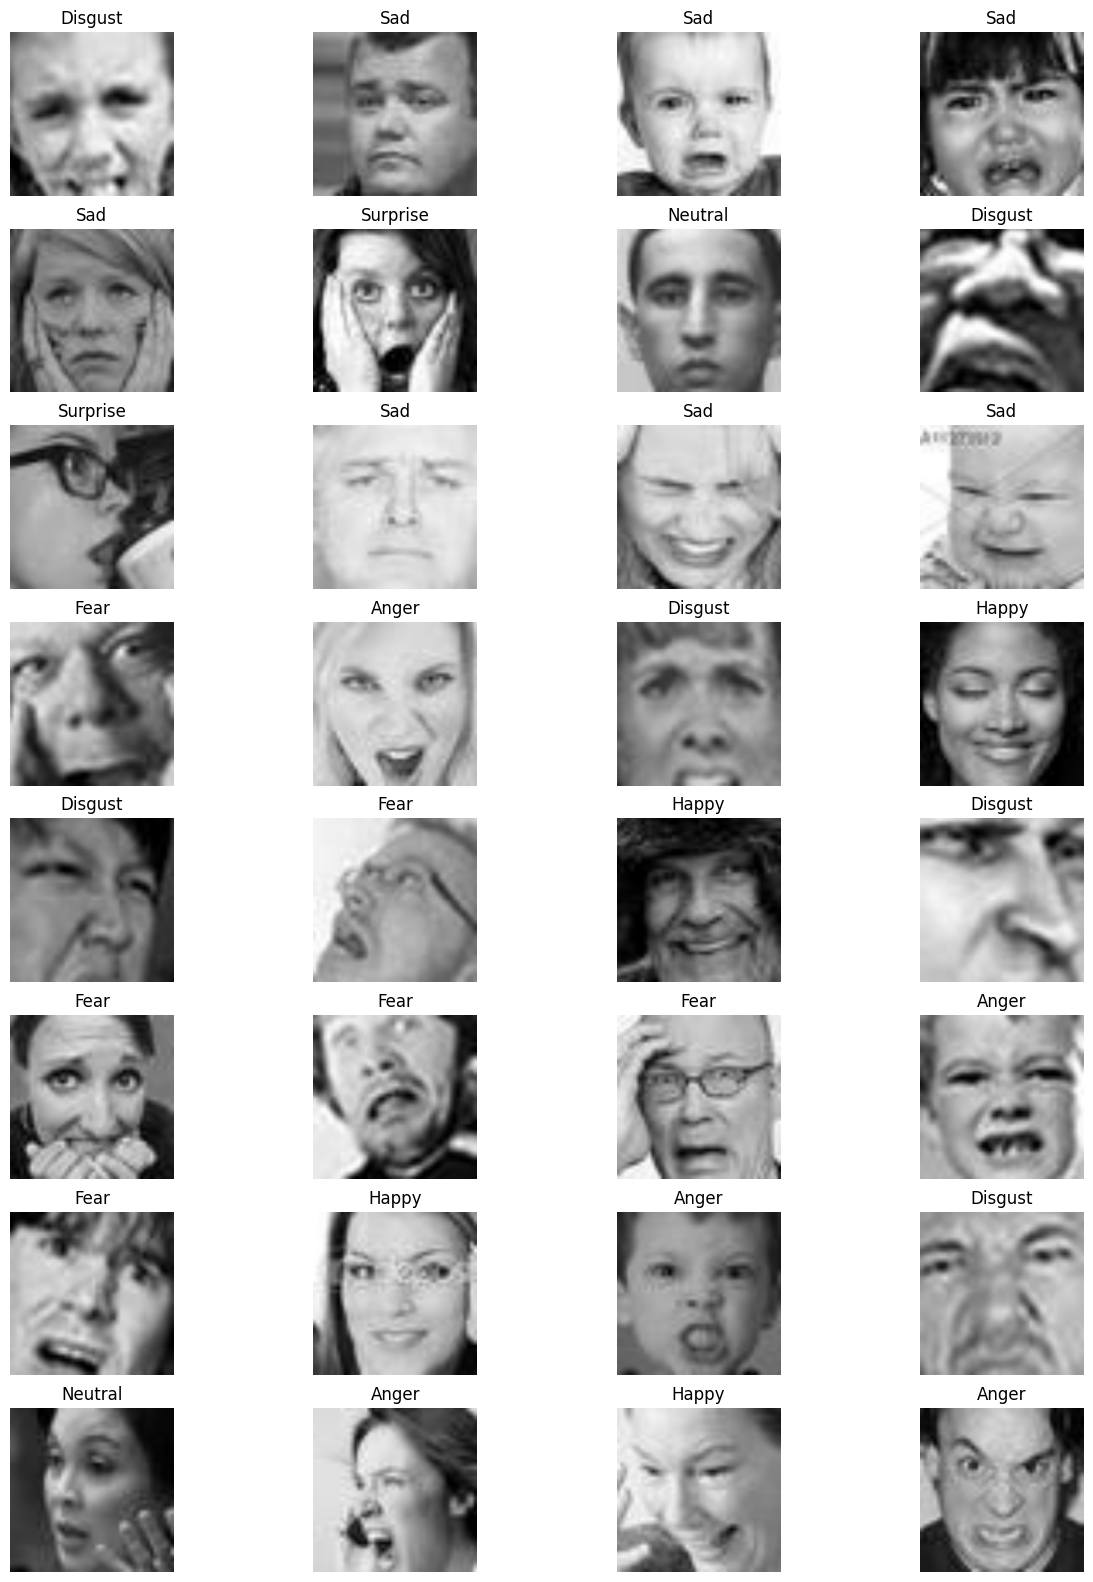

In [8]:
plt.figure(figsize=(15,20))
for i , (image , label) in enumerate(train_dataset.take(32)):
  plt.subplot(8 , 4 , i+1)
  plt.imshow(image[i].numpy().astype('uint8'))
  plt.title(labels_list[label[i].numpy()])
  plt.axis('off')

In [9]:
augment_data = tf.keras.models.Sequential([
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.RandomFlip('vertical'),
  tf.keras.layers.RandomBrightness(0.2),
])

In [10]:
def preprocess_and_augmentation_for_train(image , label):
  image = augment_data(image)
  image = tf.cast(image , tf.float32) / 255.0
  label = tf.one_hot(label,depth=len(labels_list))
  return image , label

def preprocess_and_augmentation_for_test(image , label):
  image = tf.cast(image , tf.float32) / 255.0
  label = tf.one_hot(label,depth=len(labels_list))
  return image , label

In [11]:
train_dataset = train_dataset.map(preprocess_and_augmentation_for_train , num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess_and_augmentation_for_test, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_and_augmentation_for_test)

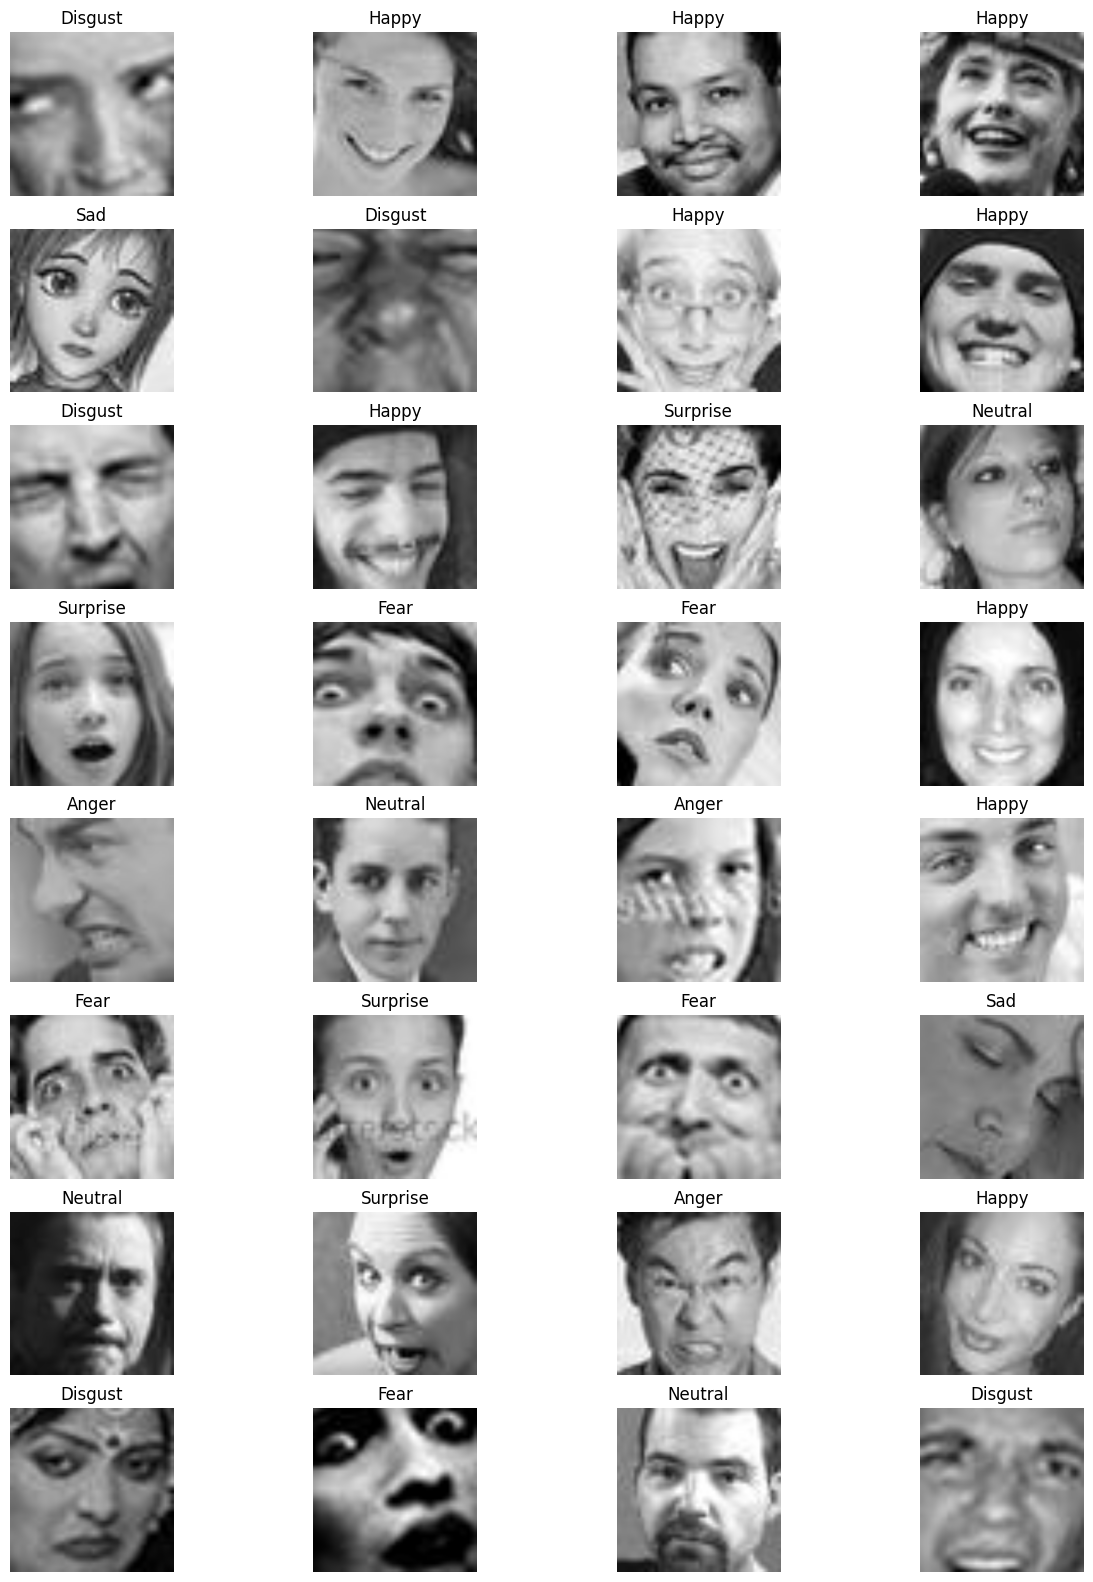

In [12]:
plt.figure(figsize=(15,20))
for i , (image , label) in enumerate(validation_dataset.take(32)):
  plt.subplot(8 , 4 , i+1)
  plt.imshow(image[i].numpy())
  plt.title(labels_list[tf.argmax(label[i])])
  plt.axis('off')

In [ ]:
total_sample = 0
class_counter = {}
for image , label in train_dataset:
  total_sample += tf.shape(label)[0]
  for i in label:
    if tf.argmax(i).numpy() in class_counter:
      class_counter[tf.argmax(i).numpy()] += 1
    else:
      class_counter[tf.argmax(i).numpy()] = 1

max_val = max(class_counter.values())
class_weights = {label: max_val/count for label, count in class_counter.items()}

In [ ]:
class_weights

{0: 1.0184012066365007,
 6: 1.0165612767238783,
 5: 1.0576441102756893,
 3: 1.0125974805038993,
 2: 1.0089659294680215,
 1: 1.0026730026730026,
 4: 1.0}

In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
epochs = 120
early_stopping_patient = 20
reduce_lr_patience = 6
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy' , factor=0.1 , patience=reduce_lr_patience)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy' , restore_best_weights=True , patience=early_stopping_patient)
checkpoint = tf.keras.callbacks.ModelCheckpoint('emotion_classification.h5' , monitor='val_loss' , save_best_only=True , save_weights_only=False, mode='min' , save_freq='epoch')
with strategy.scope():
  Metrics = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy')
  ]
  n_channels = 3
  base_model = tf.keras.applications.MobileNet(weights='imagenet' , include_top=False , input_shape=(image_size , image_size , n_channels))
  input = base_model.input
  x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dense(32 , kernel_initializer='he_uniform')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(32 , kernel_initializer='he_uniform')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(32 , kernel_initializer='he_uniform')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  output = tf.keras.layers.Dense(len(labels_list) , activation='softmax')(x)
  model = tf.keras.Model(inputs=input , outputs=output)

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4 ) , loss='categorical_crossentropy' , metrics=Metrics)

  history = model.fit(train_dataset , validation_data=validation_dataset , epochs=epochs , callbacks=[early_stopping , reduce_lr , checkpoint] , class_weight=class_weights)

17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/120
91/91 [==============================] - ETA: 0s - loss: 2.3756 - tp: 1050.0000 - fp: 4288.0000 - tn: 135218.0000 - fn: 22201.0000 - recall: 0.0452 - precision: 0.1967 - accuracy: 0.8372

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


91/91 [==============================] - 77s 422ms/step - loss: 2.3756 - tp: 1050.0000 - fp: 4288.0000 - tn: 135218.0000 - fn: 22201.0000 - recall: 0.0452 - precision: 0.1967 - accuracy: 0.8372 - val_loss: 1.9037 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 17316.0000 - val_fn: 2885.0000 - val_recall: 3.4650e-04 - val_precision: 1.0000 - val_accuracy: 0.8572 - lr: 1.0000e-04
Epoch 2/120
91/91 [==============================] - 21s 204ms/step - loss: 2.1797 - tp: 1398.0000 - fp: 3486.0000 - tn: 136020.0000 - fn: 21853.0000 - recall: 0.0601 - precision: 0.2862 - accuracy: 0.8443 - val_loss: 1.8494 - val_tp: 77.0000 - val_fp: 17.0000 - val_tn: 17299.0000 - val_fn: 2809.0000 - val_recall: 0.0267 - val_precision: 0.8191 - val_accuracy: 0.8601 - lr: 1.0000e-04
Epoch 3/120
91/91 [==============================] - 21s 210ms/step - loss: 2.0861 - tp: 1542.0000 - fp: 3088.0000 - tn: 136418.0000 - fn: 21709.0000 - recall: 0.0663 - precision: 0.3330 - accuracy: 0.8476 - val_loss: 1.7569 - val_t

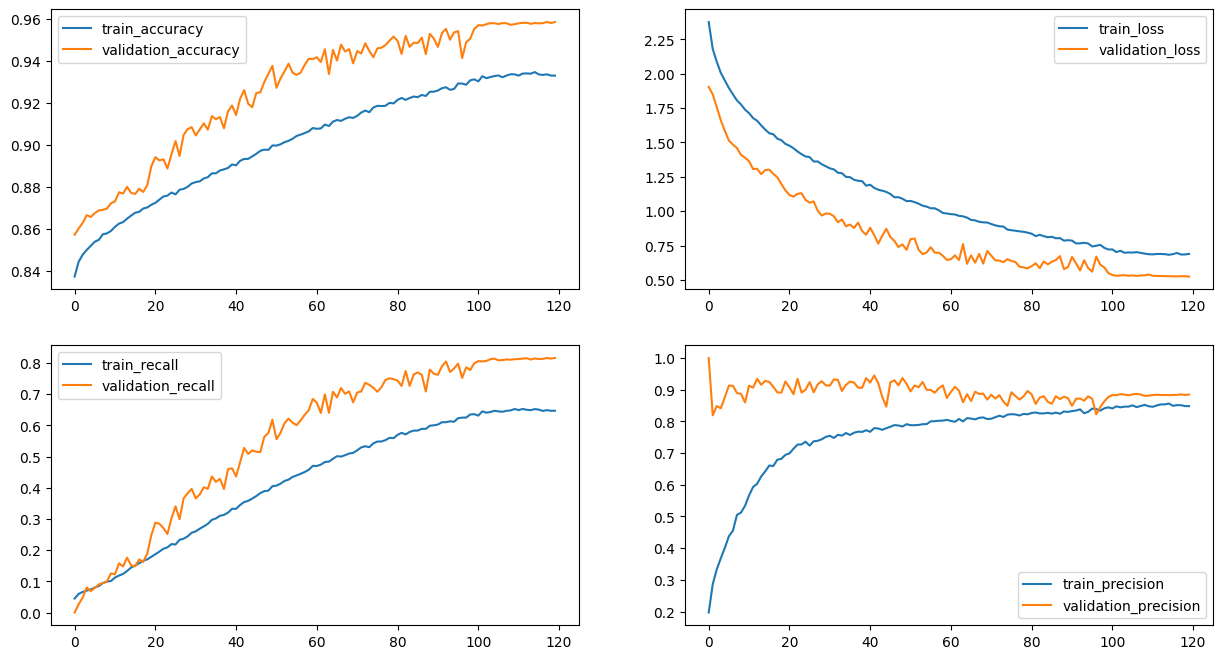

In [ ]:
plt.figure(figsize=(15, 8))
plt.subplot(2 , 2 , 1);plt.plot(history.history['accuracy'] , label='train_accuracy');plt.plot(history.history['val_accuracy'] , label='validation_accuracy');plt.legend();
plt.subplot(2 , 2 , 2);plt.plot(history.history['loss'] , label='train_loss');plt.plot(history.history['val_loss'] , label='validation_loss');plt.legend();
plt.subplot(2 , 2 , 3);plt.plot(history.history['recall'] , label='train_recall');plt.plot(history.history['val_recall'] , label='validation_recall');plt.legend();
plt.subplot(2 , 2 , 4);plt.plot(history.history['precision'] , label='train_precision');plt.plot(history.history['val_precision'] , label='validation_precision');plt.legend();


In [ ]:
model.evaluate(test_dataset)

91/91 [==============================] - 4s 21ms/step - loss: 0.5134 - tp: 2345.0000 - fp: 309.0000 - tn: 17007.0000 - fn: 541.0000 - recall: 0.8125 - precision: 0.8836 - accuracy: 0.9579


[0.5133823752403259,
 2345.0,
 309.0,
 17007.0,
 541.0,
 0.8125433325767517,
 0.883571982383728,
 0.9579249620437622]

In [13]:
loaded_model = tf.keras.models.load_model('emotion_classification.h5')

In [ ]:
model.save('emotion_classification2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
loaded_model.evaluate(test_dataset)

91/91 [==============================] - 128s 1s/step - loss: 0.5176 - tp: 2341.0000 - fp: 304.0000 - tn: 17012.0000 - fn: 545.0000 - recall: 0.8112 - precision: 0.8851 - accuracy: 0.9580


[0.5176270008087158,
 2341.0,
 304.0,
 17012.0,
 545.0,
 0.8111572861671448,
 0.8850661516189575,
 0.9579744338989258]

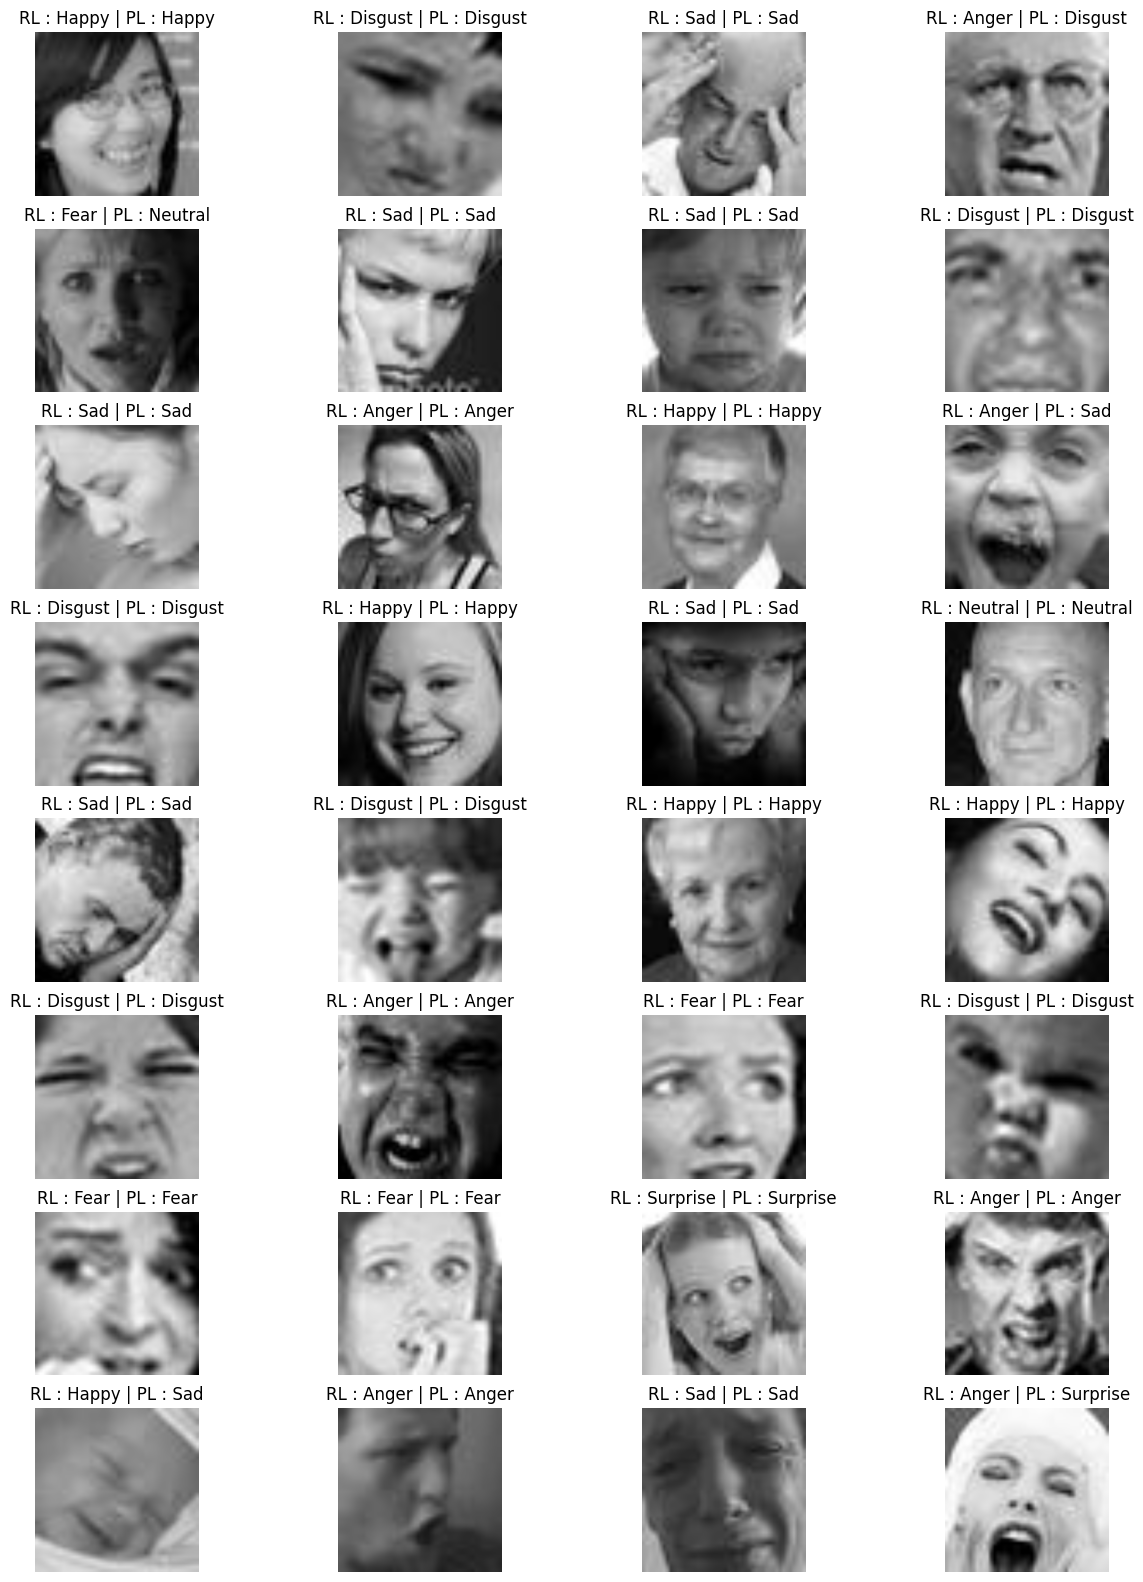

In [25]:
plt.figure(figsize=(15,20))
for i , (image , label) in enumerate(test_dataset.take(32)):
  plt.subplot(8 , 4 , i+1)
  plt.imshow(image[i].numpy())
  predicted_label = loaded_model.predict(tf.expand_dims(image[i] , axis=0) , verbose=0)
  #RL means real label PL means predicted label
  plt.title('RL : {} | PL : {}'.format(labels_list[tf.argmax(label[i])] , labels_list[tf.argmax(predicted_label[0])]))
  plt.axis('off')

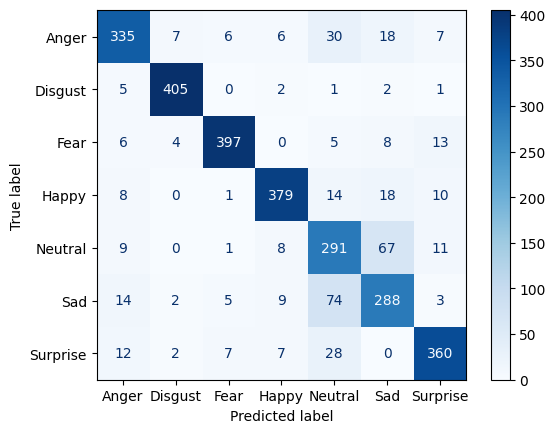

In [27]:
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = loaded_model.predict(images , verbose=0)
    y_true.append(np.argmax(labels, axis=1))
    y_pred.append(np.argmax(predictions, axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_list)
disp.plot(cmap=plt.cm.Blues)

plt.show()